# Quadrat-based statistics in `pointpats`

This notebook demonstrates quadrat-based methods for analyzing planar point
patterns using the current `pointpats.quadrat_statistics` implementation.

The workflow is:

1. Represent the point pattern as a NumPy array of coordinates with shape `(n, 2)`.
2. Construct a rectangular or hexagonal quadrat tessellation over the **minimum
   bounding box (MBB)** of the points.
3. Compute a Pearson chi-square statistic from per-quadrat counts.
4. Optionally, obtain a **Monte Carlo p-value** by simulating CSR realizations
   within the same study window, with reproducibility controlled by `rng`.

Key implementation facts (relevant for interpretation):

- The default chi-square statistic uses **equal expected counts** across included cells.
- A `window` may be supplied; if omitted, the MBB rectangle is used.
- Monte Carlo inference makes the reference distribution window-aware, but it does not
  change how expected counts are defined.


## 1. Quadrat statistics and CSR

Quadrat analysis partitions space into a set of non-overlapping cells and compares
the observed counts per cell to what is expected under **complete spatial randomness (CSR)**.

Let $O_i$ be the count in cell \(i\), and let \(k\) be the number of cells
included in the analysis. The implemented test statistic is the Pearson chi-square
statistic with **equal expected counts** across included cells:

$$
X^2 = \sum_{i=1}^k \frac{(O_i - \bar{O})^2}{\bar{O}},
\qquad
\bar{O} = \frac{1}{k} \sum_{i=1}^k O_i.
$$

Analytical inference compares $X^2$  to a chi-square distribution with $(k-1)$
degrees of freedom. Simulation-based inference (Monte Carlo) instead compares the
observed $X^2$ to the sampling distribution obtained from CSR realizations
generated in the same window.


## 2. Example: the juvenile delinquency point pattern

We will illustrate the quadrat workflow using the `juvenile.shp` example dataset.
The dataset is read as a GeoDataFrame and then converted to a NumPy coordinate array
`xy` with shape `(n, 2)`.

These coordinates are passed directly to `QStatistic`.


In [1]:
import libpysal as ps
import numpy as np
import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Import `pointpats.quadrat_statistics` and compute quadrat statistics.

The main entry point is:

```python
QStatistic(points, shape="rectangle"|"hexagon", realizations=0, window=None,
           drop_nonintersecting=False, rng=None)
```

- `points` is always a NumPy array of shape `(n, 2)`.
- `shape` selects the tessellation type.
- `realizations > 0` enables Monte Carlo inference.
- `rng` controls reproducibility of simulations.


In [2]:
from pointpats.quadrat_statistics import QStatistic

Open the point shapefile and extract coordinates.

Here we use `GeoDataFrame.get_coordinates()` to obtain an `(n, 2)` NumPy array,
which is the required input type for `QStatistic`.


In [3]:
juv = gpd.read_file((ps.examples.get_path("juvenile.shp")))

In [4]:
juv.shape

(168, 4)

In [5]:
xy = juv.get_coordinates()

In [6]:
xy

,x,y
0,94.0,93.0
1,80.0,95.0
2,79.0,90.0
3,78.0,92.0
4,76.0,92.0
...,...,...
163,45.0,14.0
164,33.0,8.0
165,31.0,7.0
166,32.0,6.0


In [7]:
resRect = QStatistic(xy)

In [8]:
resRect.chi2_pvalue

np.float64(5.890978545159614e-05)

<Axes: title={'center': 'Quadrat Count'}>

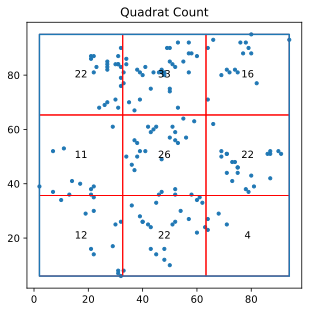

In [9]:
resRect.plot()

In [10]:
resHex = QStatistic(xy, shape='hexagon')

<Axes: title={'center': 'Quadrat Count'}>

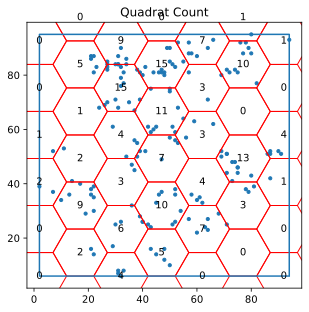

In [11]:
resHex.plot()

In [12]:
resHex.chi2_pvalue

np.float64(6.375950695202749e-22)

## 3. Simulation-based inference (Monte Carlo)

When `realizations > 0`, CSR realizations are generated **within the same window**
and the chi-square statistic is recomputed for each realization. The Monte Carlo
p-value uses the standard +1 correction:

$$
p = \frac{\#\{X^2_{sim} \ge X^2_{obs}\} + 1}{R + 1},
$$

where $R$ is the number of realizations.

### Reproducibility

All simulation-based results can be made reproducible by supplying `rng`:

- `None` (default): create a new `numpy.random.default_rng()`
- integer seed
- `numpy.random.Generator`
- legacy `numpy.random.RandomState` (wrapped)

The same generator is passed through the CSR simulation code, ensuring repeatable
Monte Carlo p-values.


In [13]:
from numpy.random import default_rng

In [14]:
rng = default_rng(42)

In [15]:
resHex_sim = QStatistic(xy, shape='hexagon', realizations=99, rng=rng)

In [16]:
resHex_sim.chi2_r_pvalue


np.float64(0.01)

In [17]:
resHex_sim.chi2_realizations

array([ 97.5       ,  59.        ,  69.        ,  67.5       ,
        70.        ,  58.5       ,  60.5       ,  78.        ,
        60.        ,  54.5       ,  65.5       ,  72.5       ,
        83.        ,  92.5       ,  98.5       ,  90.5       ,
        62.        ,  83.        ,  74.        ,  68.        ,
        79.5       ,  64.5       ,  52.5       ,  59.        ,
        63.5       ,  59.        ,  70.        , 101.5       ,
        66.5       ,  76.        ,  49.5       ,  39.07142857,
        70.5       ,  89.5       ,  88.5       ,  62.5       ,
        72.        ,  76.5       ,  55.        ,  62.        ,
        63.21428571,  88.        ,  52.5       ,  65.        ,
        91.        ,  54.85714286,  61.        ,  45.5       ,
        61.        ,  67.5       ,  64.        ,  59.5       ,
        72.5       ,  58.        ,  68.5       ,  62.5       ,
        84.5       ,  74.5       ,  69.5       ,  51.        ,
        65.        ,  39.5       ,  80.        ,  70.  

In [18]:
resHex_sim.chi2

np.float64(195.0)

## 4. Irregular windows

Quadrat grids are constructed over the MBB of the points. If the study window is
irregular (e.g., a polygon), some grid cells may lie entirely outside the window.

- If such outside cells are included, they contribute guaranteed zeros and can
  distort the test.


### How Monte Carlo interacts with this

Comparing the observed chi-square statistic to simulated chi-square values is a
valid Monte Carlo test **for the statistic being used**, because the same grid,
window, and inclusion rule are applied to both observed and simulated patterns.

Monte Carlo inference makes the *reference distribution* window-aware, but it does
not convert the test into an area-proportional quadrat test when the window is irregular.


In [19]:
from shapely.geometry import Polygon

In [20]:
window = Polygon([ [0, 0], [1, 0], [0, 1] ])

In [21]:
from pointpats.random import poisson

In [22]:
pp = poisson(window, 100/1, rng=42)

In [23]:
pp

array([[0.12811363, 0.45038594],
       [0.4434142 , 0.22723872],
       [0.55458479, 0.06381726],
       [0.7783835 , 0.19463871],
       [0.466721  , 0.04380377],
       [0.15428949, 0.68304895],
       [0.32582536, 0.37045971],
       [0.46955581, 0.18947136],
       [0.12992151, 0.47570493],
       [0.22690935, 0.66981399],
       [0.38747838, 0.2883281 ],
       [0.6824955 , 0.13975248],
       [0.1999082 , 0.00736227],
       [0.139797  , 0.11453007],
       [0.55920716, 0.3039501 ],
       [0.03081783, 0.43671739],
       [0.21458467, 0.40852864],
       [0.05830274, 0.28138389],
       [0.29359376, 0.66191651],
       [0.81402038, 0.16697292],
       [0.02271207, 0.09004786],
       [0.16127178, 0.50104478],
       [0.1523121 , 0.69632038],
       [0.44615628, 0.38102123],
       [0.30151209, 0.63028259],
       [0.36181261, 0.08764992],
       [0.4493615 , 0.27224156],
       [0.09639096, 0.9026024 ],
       [0.45577629, 0.20236336],
       [0.30595662, 0.57921957],
       [0.

In [24]:
qs = QStatistic(pp, nx=5, ny=5)

<Axes: title={'center': 'Quadrat Count'}>

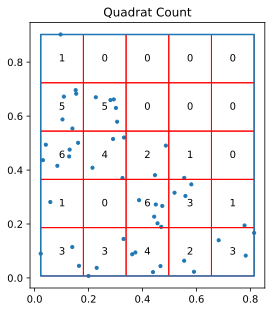

In [25]:
qs.plot()

In [26]:
qs.chi2_pvalue

np.float64(0.0010544670440019426)

In [27]:
qsw = QStatistic(pp, nx=5, ny=5, window=window, realizations=99, rng=42)

In [28]:
qsw.chi2_r_pvalue

np.float64(0.37)

<Axes: title={'center': 'Quadrat Count'}>

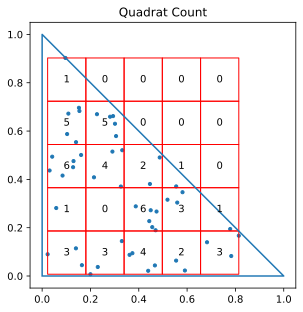

In [29]:
qsw.plot()

## 5. Recap

In this notebook, we:

- represented a point pattern as an `(n, 2)` NumPy coordinate array,
- computed quadrat counts using rectangular and hexagonal tessellations over the MBB,
- used a Pearson chi-square statistic with equal expected counts across included cells,
- obtained either an analytical p-value or a Monte Carlo p-value from CSR realizations,
- clarified the issues associated with irregular windows, and
- ensured reproducibility of simulations via an explicit `rng`.